In [298]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
from sklearn.datasets import load_breast_cancer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import arviz
import pystan

In [232]:
# 肺ガンデータセットのロード
data = load_breast_cancer()
print(data.data.shape)

(569, 30)


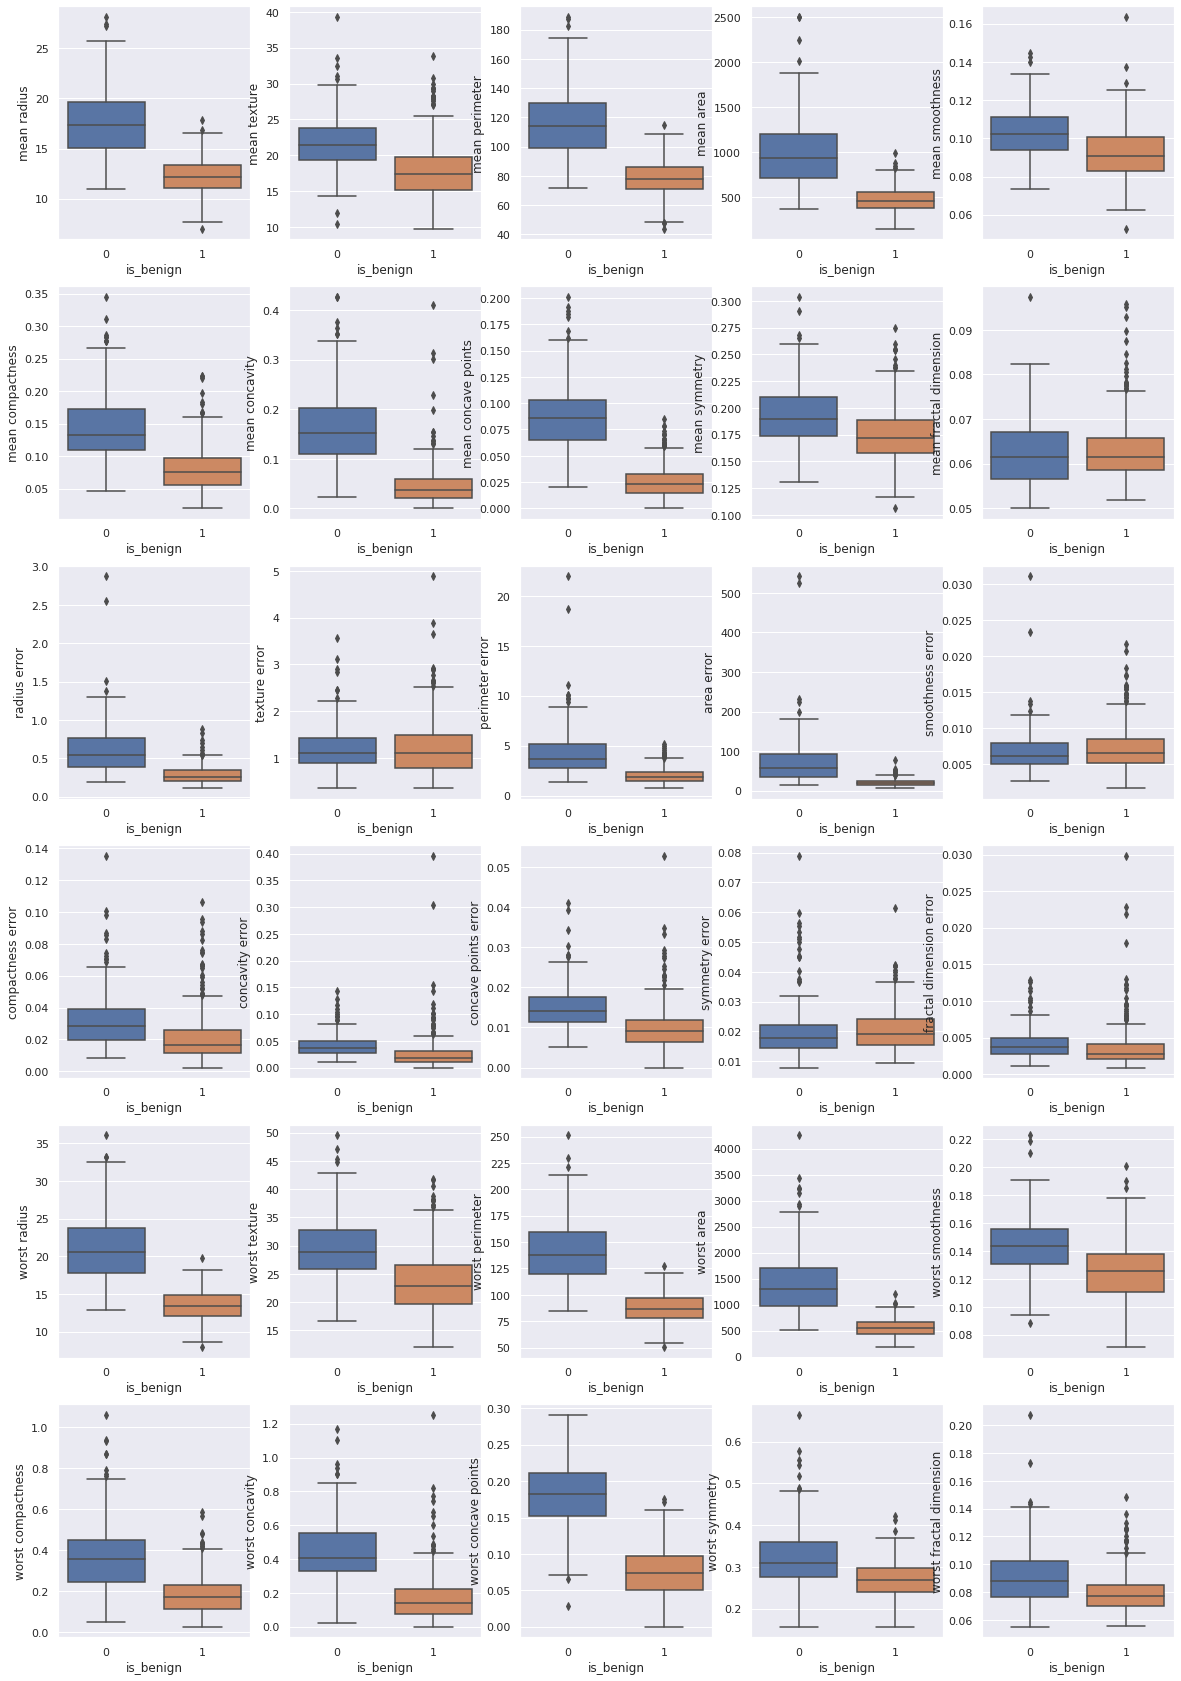

In [230]:
# 目的変数と説明変数のboxplot
df_viz = pd.concat(
    [pd.DataFrame(data.target, columns=['is_benign']), pd.DataFrame(data.data, columns=data.feature_names)],
    axis=1
)
plt.figure(figsize=(20, 30))
for i, feature in enumerate(data.feature_names):
    plt.subplot(6, 5, i+1)
    sns.boxplot(x='is_benign', y=feature, data=df_viz)

In [204]:
def get_high_corr_pairs(df, thred=0.8):
    """
    相関係数が閾値以上の変数の組み合わせを取得する
    """
    pairs = list()
    variables = list(df.columns)
    for num, row in enumerate(np.array(df.corr())):
        over_index = np.where(row[num + 1:] > thred)[0]
        if len(over_index) > 0:
            pairs.extend([(variables[num], variables[index + 1]) for index in over_index])
    return pairs

In [234]:
df_feature = pd.DataFrame(data.data, columns=data.feature_names)
print(len(get_high_corr_pairs(df_feature, thred=0.8)))

44


In [173]:
def drop_col_by_vif(df, thred=10):
    """
    VIF値が閾値を超える変数を削除する
    """
    def get_max_vif(df):
        """
        VIF値が最大の変数とVIF値を取得する
        """
        vif = np.array([variance_inflation_factor(df.values, i) for i in range(df.shape[1])])
        variable = np.array(df.columns)[np.argmax(vif)]
        max_vif = np.max(vif)
        
        return variable, max_vif
    
    df_ = df.copy()
    # 閾値未満のVIF値が存在しなくなれば処理終了
    while True:
        variable, max_vif = get_max_vif(df_)
        if max_vif > thred:
            print(f'drop variable:{variable}, VIF:{max_vif}')
            df_.drop(columns=variable, inplace=True)
        else:
            break
    
    return df_

In [174]:
# VIF値が閾値を超える変数を削除する
df = drop_col_by_vif(df_feature, thred=10)

drop variable:mean radius, VIF:63306.17203588469
drop variable:worst radius, VIF:7573.943486033555
drop variable:mean perimeter, VIF:3901.901687119607
drop variable:worst perimeter, VIF:668.3854404127386
drop variable:mean fractal dimension, VIF:508.08682464149285
drop variable:worst smoothness, VIF:368.0533791867144
drop variable:worst texture, VIF:309.54444960438434
drop variable:worst fractal dimension, VIF:184.67972071700538
drop variable:worst symmetry, VIF:167.30971478504884
drop variable:mean concavity, VIF:142.29904340088856
drop variable:radius error, VIF:104.99215955661566
drop variable:worst concave points, VIF:100.94649021325061
drop variable:mean smoothness, VIF:86.99658368431041
drop variable:mean compactness, VIF:74.72314541276282
drop variable:mean area, VIF:67.47169344522399
drop variable:worst compactness, VIF:49.02308700997905
drop variable:perimeter error, VIF:43.72833047786977
drop variable:mean symmetry, VIF:36.0757931560618
drop variable:mean texture, VIF:23.7099

In [237]:
print(f'selected variables:{list(df.columns)}')

selected variables:['texture error', 'area error', 'smoothness error', 'concavity error', 'symmetry error', 'fractal dimension error', 'worst concavity']


# pystanでGLM, GLMMを構築

In [148]:
# デザイン行列
X = df
X['intercept'] = 1
#目的変数
Y = data.target
# 行列・ベクトルサイズ
N, K = df.shape

In [226]:
# 一般化線形モデル
glm = """
data{ 
  int N;
  int K;
  int Y[N];
  matrix[N, K] X;
}

parameters{
  vector[K] b;
}

model{
  vector[N] p = X * b;
  Y ~ bernoulli_logit(p);
}
"""
fit = pystan.stan(model_code=glm, data={'N': N, 'K': K, 'Y': Y, 'X': X}, warmup=1000, iter=2000, chains=4)

In [239]:
print(fit)

Inference for Stan model: anon_model_761a478f1c9b45406c71aeb93621ae8e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1]  -0.14    0.01   0.55  -1.16  -0.52  -0.15   0.23   0.93   2519    1.0
b[2]  -0.23  8.0e-4   0.03  -0.29  -0.25  -0.23  -0.21  -0.17   1532    1.0
b[3] -382.6    2.95 124.97 -624.9 -466.8 -383.1 -295.8 -135.4   1794    1.0
b[4]  110.8    0.68  26.13  66.55  92.27 108.64 127.51 167.26   1464    1.0
b[5]  -8.47    0.68  36.38 -86.12 -30.96  -6.79  15.84  59.24   2876    1.0
b[6] 732.07    4.87 226.53 301.16 580.38  726.4 877.75 1187.0   2166    1.0
b[7] -30.08    0.13   4.14  -38.8 -32.82 -29.91 -27.14 -22.58    986    1.0
b[8]  13.23    0.05   1.74  10.11  11.98  13.17  14.38  16.79   1109    1.0
lp__ -65.03    0.06   2.09 -69.99  -66.1 -64.68 -63.54  -62.0   1369    1.0

Samples were drawn using NUTS at Sat Jan 16 03:42:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f54d62ff610>,
      dtype=object)

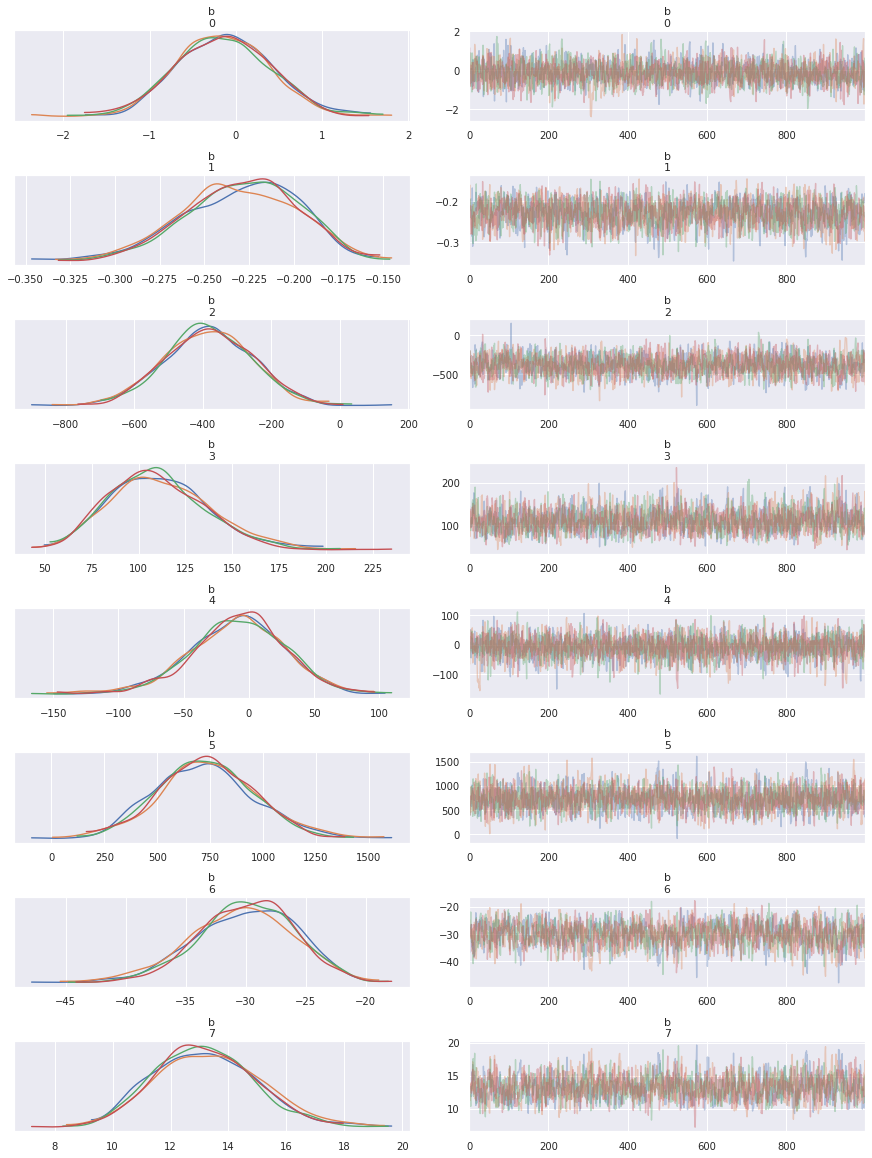

In [292]:
arviz.plot_trace(fit)

In [263]:
list(X.columns)

['texture error',
 'area error',
 'smoothness error',
 'concavity error',
 'symmetry error',
 'fractal dimension error',
 'worst concavity',
 'intercept']

In [258]:
glmm = """
data{
  int N;
  int K;
  int Y[N];
  matrix[N, K] X;
}

parameters{
  vector[K] b;
  vector[N] r;
  real<lower=0> sigma;
}

model{ 
  vector[N] p = X * b + r;
  r ~ normal(0, sigma);
  Y ~ bernoulli_logit(p);
}
"""
fit_glmm = pystan.stan(model_code=glmm, data={'N': N, 'K': K, 'Y': Y, 'X': X}, warmup=1000, iter=2000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_baf824ebc8a4da7810996238f5cd4276 NOW.


In [296]:
print(fit_glmm.stansummary(pars=['b', 'sigma']))

Inference for Stan model: anon_model_baf824ebc8a4da7810996238f5cd4276.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1]   26.59   18.14   83.9 -137.4 -18.96  12.82  72.36 219.97     21   1.16
b[2]  -33.65    11.3  19.29 -70.25 -48.92 -32.63 -14.85  -0.45      3   2.98
b[3]  -6.3e4   2.1e4  4.1e4 -1.5e5 -9.0e4 -5.8e4 -2.9e4 -829.2      4   1.93
b[4]   1.6e4  5489.3  1.0e4 201.41 7315.2  1.5e4  2.3e4  3.8e4      3   2.29
b[5]   -1985  1133.2 6080.8 -1.6e4  -5191 -713.2 1199.0 9631.5     29   1.18
b[6]   1.0e5   3.3e4  6.4e4 1430.0  4.8e4  1.0e5  1.4e5  2.4e5      4   1.76
b[7]   -4354  1486.1 2530.6  -8950  -6528  -4096  -2321 -59.47      3   2.95
b[8]  1946.8  663.07 1125.5  25.62 983.73 1853.2 2950.9 3893.2      3   3.11
sigma 275.96   94.89  157.2   2.96 144.51 255.45 410.32 535.41      3   3.72

Samples were drawn using NUTS at Sat Jan

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f54d4c15710>,
      dtype=object)

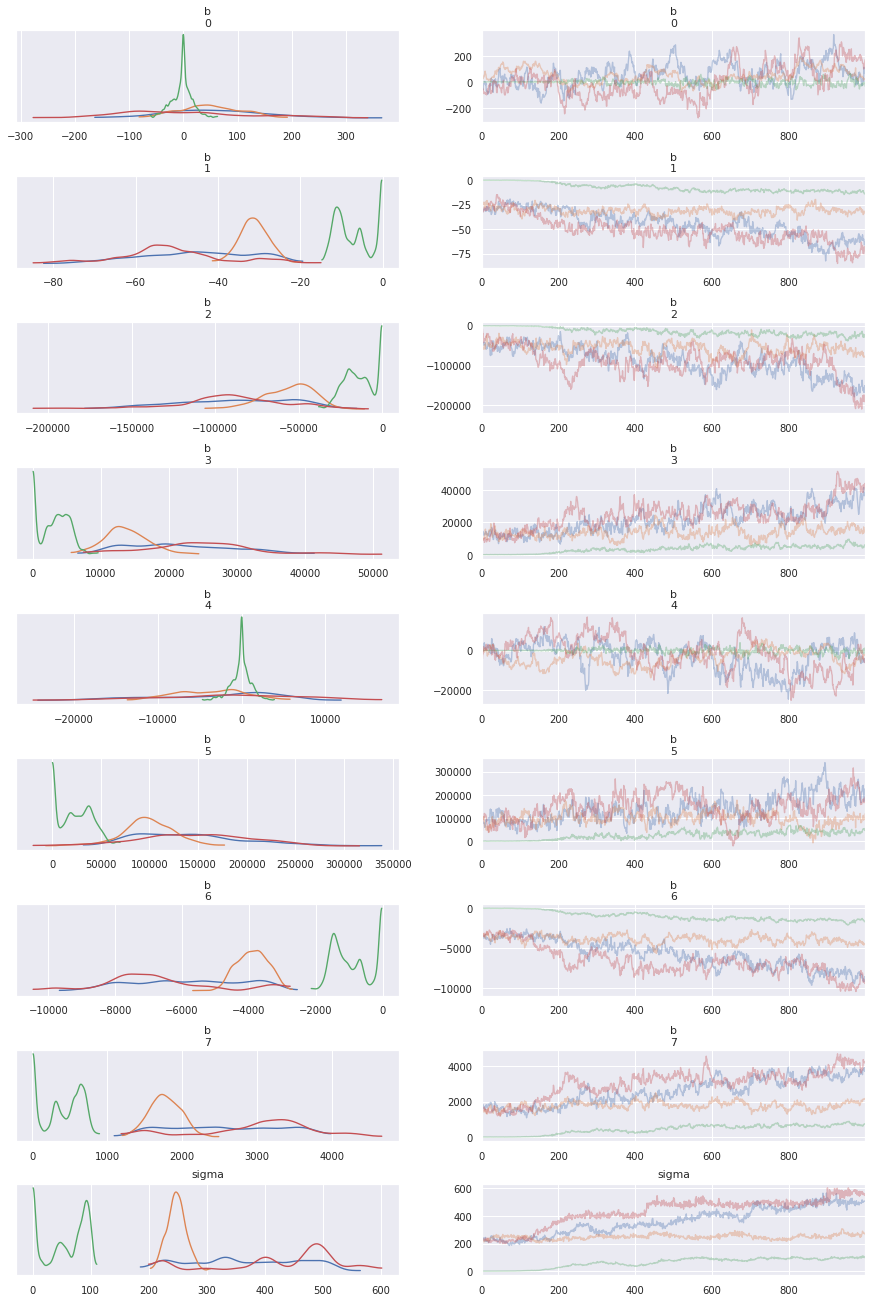

In [293]:
arviz.plot_trace(fit_glmm, var_names=('b', 'sigma'))